In [7]:
from spectral import *
import numpy as np
import matplotlib.pyplot as plt
import math

import sys; sys.path.append("../../python")
from farmers import HyperspectralImage as hsi

In [2]:
FOLDER_TO_OPEN = "C:\\Users\\Alex\\Desktop\\Q171_test"#"C:\\Users\\Alex\\HyperspectralPlantImaging\\TestImages\\WHU-HI"

images = hsi.get_envi_hsi_from_directory(FOLDER_TO_OPEN, ".hdr", ".raw")

first_image = images[0]

header_file, data_file = first_image

image = hsi.load_image(header_file, data_file)

c:\Users\Alex\anaconda3\envs\gpu_tf\lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


ImageView object:
  Display bands       :  [64, 25, 3]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-7.59375, 474.734375]
    G: [-12.96875, 435.84375]
    B: [-14.359375, 379.390625]

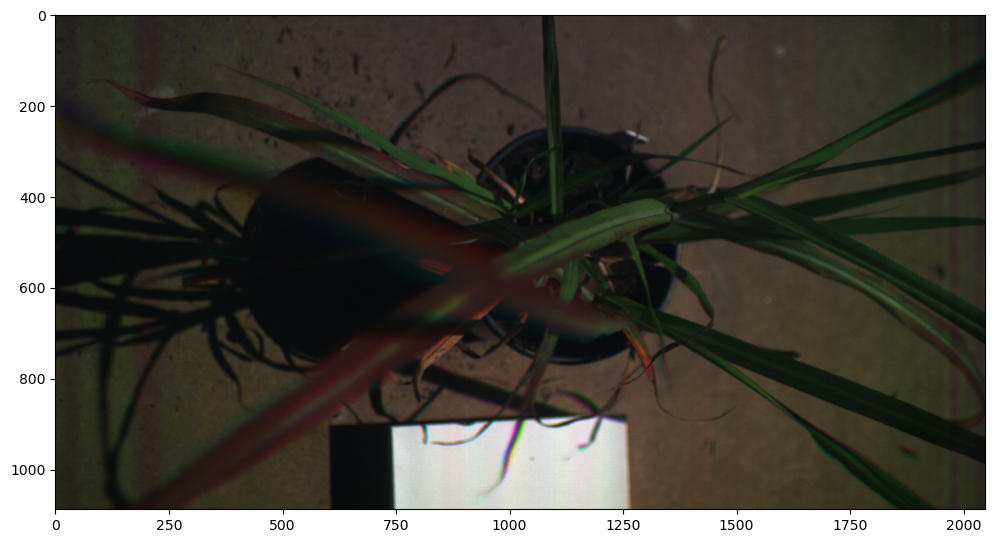

In [3]:
bands = image.bands.centers

RCB_WAVELENGTHS = [650, 550, 400]
rcb_bands = [hsi.get_closest_band_for_wavelength(bands, wavelength) for wavelength in RCB_WAVELENGTHS]

imshow(image, rcb_bands, figsize=(12,12))

In [4]:
from ipywidgets import interact

bands = np.array(image.bands.centers)
wavelengths = tuple([int(bands.min()), int(bands.max())])

def render_hsi(red, cyan, blue):
    red_band = hsi.get_closest_band_for_wavelength(bands, red)
    cyan_band = hsi.get_closest_band_for_wavelength(bands, cyan)
    blue_band = hsi.get_closest_band_for_wavelength(bands, blue)

    imshow(image, (red_band,cyan_band,blue_band), figsize=(12,12))

interact(render_hsi, red=(wavelengths), cyan=(wavelengths), blue=(wavelengths))

interactive(children=(IntSlider(value=450, description='red', max=901), IntSlider(value=450, description='cyan…

<function __main__.render_hsi(red, cyan, blue)>

ImageView object:
  Display bands       :  [64, 25, 3]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-18.9375, 20.078125]
    G: [-23.453125, 22.921875]
    B: [-23.8125, 20.53125]

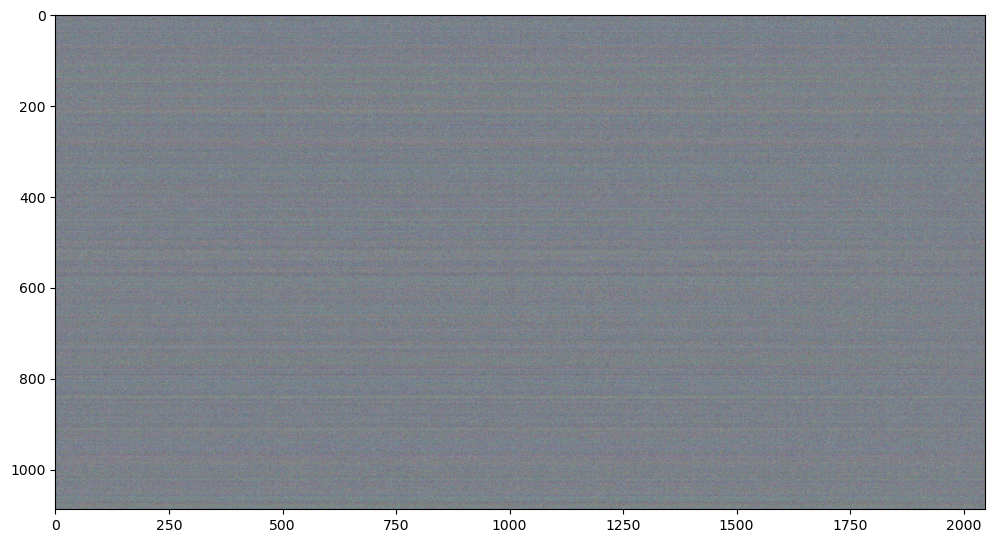

In [5]:
DARK_REFERENCE_IMAGE = (
   "C:\\Users\\Alex\\OneDrive - Swinburne University\\SRA_Sugarcane_Data(Original HSI)\\dark_ref_irradiance.hdr",
   "C:\\Users\\Alex\\OneDrive - Swinburne University\\SRA_Sugarcane_Data(Original HSI)\\dark_ref_irradiance.raw"
)

dark_reference_matrix = hsi.load_as_matrix(*DARK_REFERENCE_IMAGE)

imshow(dark_reference_matrix, rcb_bands, figsize=(12,12))

c:\Users\Alex\anaconda3\envs\gpu_tf\lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


ImageView object:
  Display bands       :  [64, 25, 3]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-3.9389915466308594, 107.67837524414062]
    G: [-4.541626930236816, 98.77626037597656]
    B: [-5.747908115386963, 86.08448791503906]

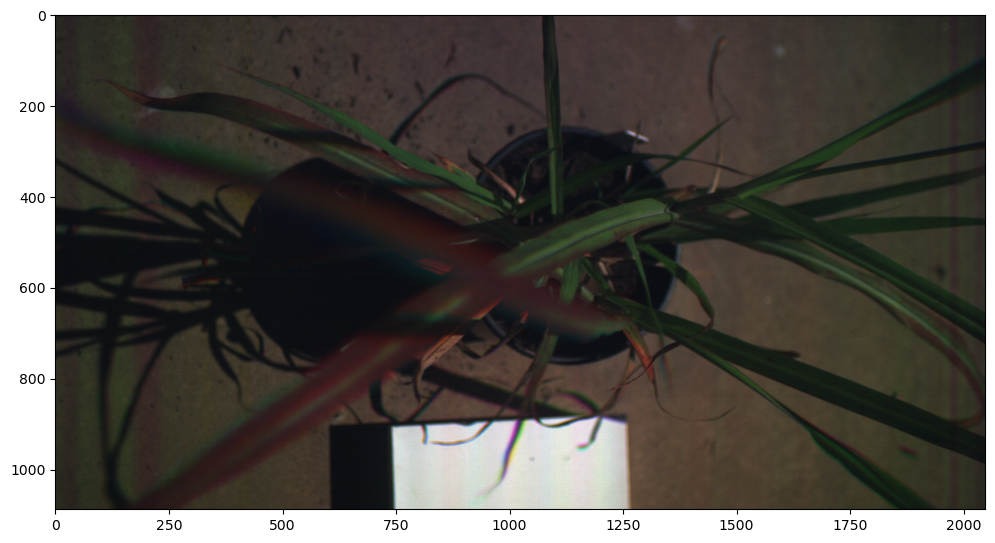

In [6]:
image_matrix = hsi.to_matrix(image)
image_matrix_2d = hsi.matrix_reshape_2d(image_matrix)

# Image Calibration via K-Means clustering to extract white reference
kmeans = hsi.lloyd_kmeans_plus(image_matrix_2d)

white_ref_matrix = image_matrix_2d[kmeans.labels_ == 1]

calibrated_image = hsi.calibrate_image(image, dark_reference_matrix, white_ref_matrix)

imshow(calibrated_image, rcb_bands, figsize=(12,12))

ImageView object:
  Display bands       :  [64, 25, 3]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-3.9389915466308594, 75.43829345703125]
    G: [-3.582886219024658, 84.36068725585938]
    B: [-4.5594611167907715, 49.24517822265625]

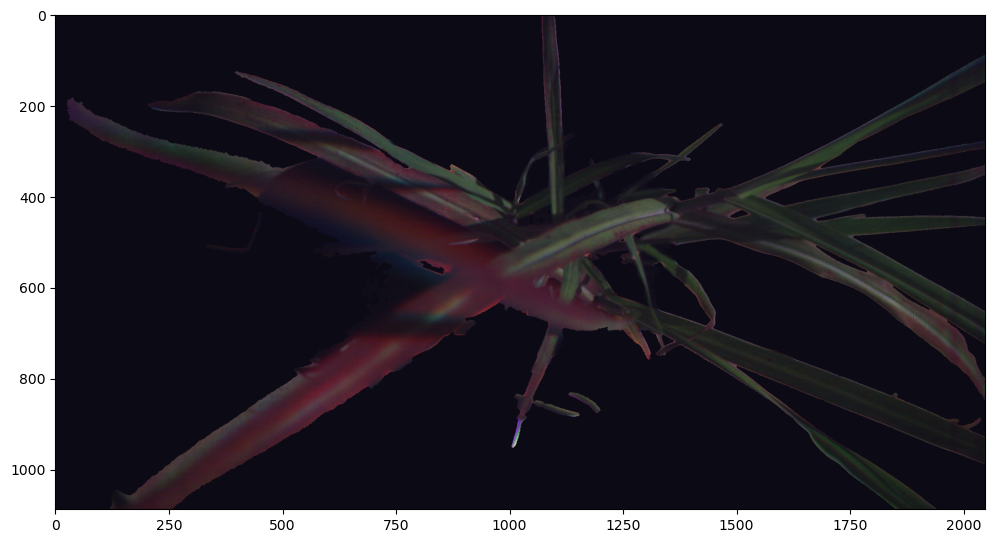

In [8]:
# Image segmentation
segmented_image = hsi.segment_image(calibrated_image, bands)

imshow(segmented_image, rcb_bands, figsize=(12,12))

In [10]:
CHUNK_SIZE = 64

image_chunks = hsi.slice_hsi_into_chunks(
    segmented_image,
    chunk_size = 64,
    enforce_chunk_size = True,
    minimum_plant_ratio = 0
)

image_size = list(segmented_image.shape[:-1])

num_columns = int(math.ceil(image_size[1] / CHUNK_SIZE))

# Graph the chunks of the HSI

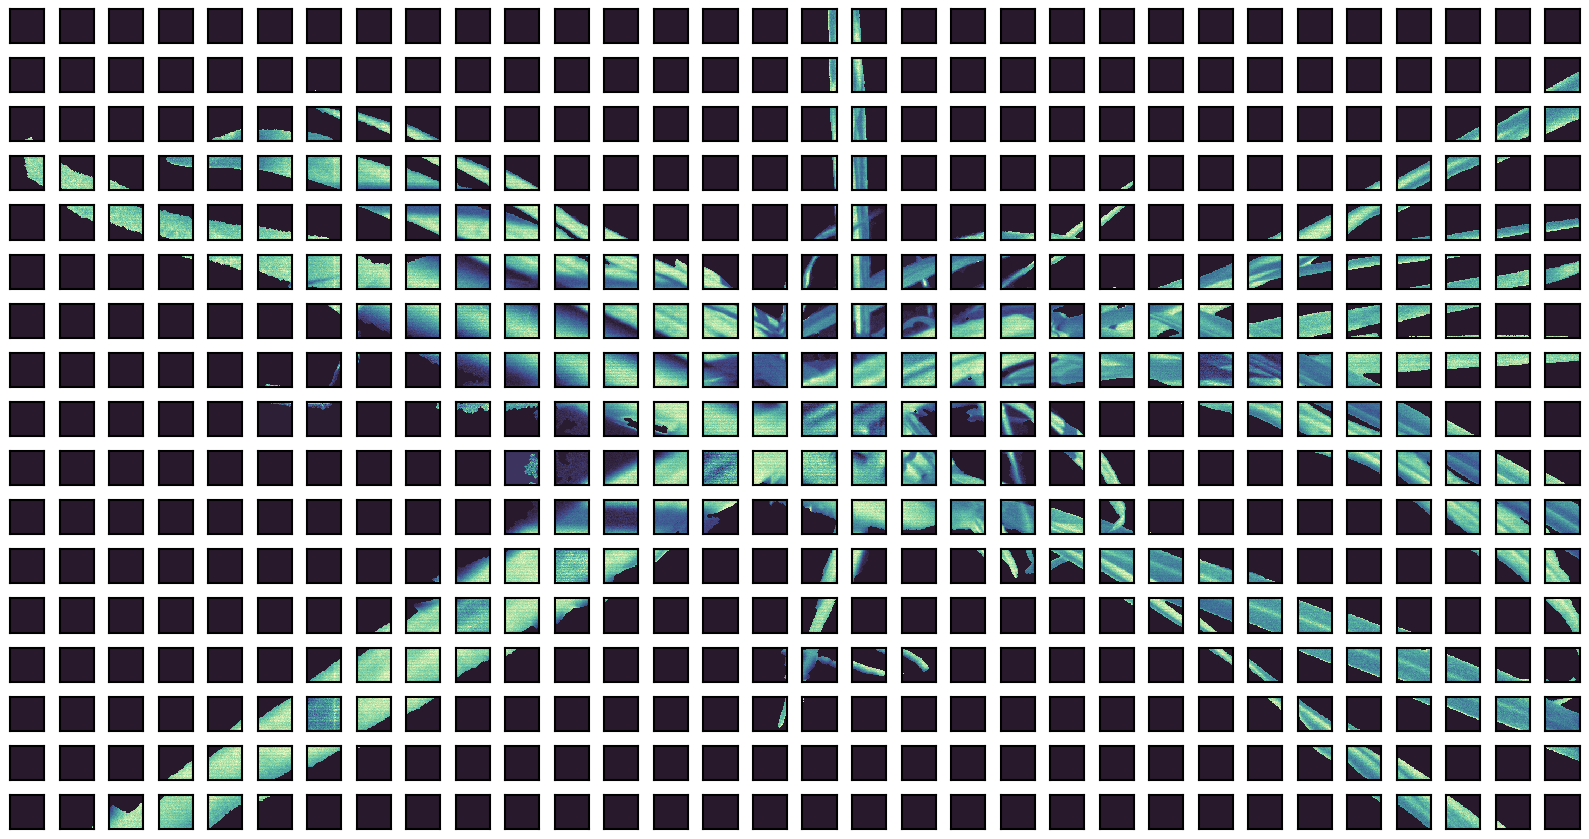

In [110]:
#%pip install -U seaborn-image
import seaborn_image as isns

chunks = [chunk[:,:,100] for chunk in image_chunks]

grid = isns.ImageGrid(chunks, cbar=False, height=0.5, col_wrap=num_columns)